In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
from scipy import integrate,special

In [130]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 0.012/x0
z_start = 0.012/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=0./Gamma,b=-0.4/Gamma,c=0.,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [131]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        result = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return result
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -11
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [132]:
def vc_bayesian(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>30 or y[-2]*1000*x0>30:
            val = -1.
        else:
            val=1.
        return val
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0s,v0s,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 0,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    if len(sol.t_events[0])==1:
        return v0s
    else:
        return -1.

In [108]:
start = time.time()

print(vc_bayesian(5.8,1.252,-2.5,0.22,-0.6,-0.4,15,20,23,21,-1,-1,1,1))  

print(time.time()-start)

5.8
9.297142028808594


In [109]:
pbounds = {'v0s':(2,8),'Bgrad':(0.5,2),'d1':(-3,1),'d2':(-3,1),'d3':(-3,1),'d4':(-3,1),'p1':(0,50),'p2':(0,50),'p3':(0,50),'p4':(0,50),'pol1':(-1,1),'pol2':(-1,1),'pol3':(-1,1),'pol4':(-1,1)}

In [110]:
optimizer = BayesianOptimization(
    f = vc_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [111]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.0      |  1.126    | -0.1187   | -3.0      | -1.791    | -2.413    |  4.617    |  9.313    |  17.28    |  19.84    |  0.07763  | -0.1616   |  0.3704   | -0.5911   |  7.269    |
|  2        | -1.0      |  1.089    | -0.5539   | -0.8439   | -2.181    | -2.332    |  24.15    |  28.56    |  2.302    |  30.67    | -0.5294   | -0.2846   |  0.7505   |  0.5304   |  2.657    |
18.930384874343872


In [11]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["./logs_update.json"])

|  3        |  2.234    |  1.034    | -0.3181   | -1.331    | -0.7652   | -2.438    |  9.905    |  40.04    |  48.41    |  15.67    |  0.3846   |  0.7528   |  0.7892   | -0.8299   |  2.234    |
|  4        | -1.0      |  3.812    |  0.5126   | -2.607    | -1.316    |  0.8316   |  26.66    |  34.59    |  15.78    |  34.33    |  0.6693   | -0.9634   |  0.5003   |  0.9777   |  6.489    |
|  5        | -1.0      |  5.969    |  0.1571   | -2.587    | -1.208    |  0.6344   |  14.68    |  14.39    |  6.501    |  0.9683   |  0.3577   | -0.5767   | -0.4689   | -0.01685  |  2.32     |
|  6        | -1.0      |  11.7     | -2.413    | -0.6428   | -0.201    | -2.591    |  20.7     |  34.72    |  20.71    |  2.498    |  0.07179  |  0.3276   |  0.02978  |  0.8892   |  5.519    |
|  7        |  4.093    |  18.12    | -2.45     | -2.443    |  0.2296   | -1.409    |  8.268    |  46.38    |  17.39    |  37.54    |  0.452    |  0.7666   |  0.2473   |  0.5019   |  4.093    |
|  8        | -1.0      |  5.7

In [20]:
len(optimizer.res)

2

In [112]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_0414.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [113]:
start = time.time()
optimizer.maximize(
    init_points=30,
    n_iter=100,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  3        | -1.0      |  0.5411   | -0.3181   | -1.331    | -0.7652   | -2.438    |  9.905    |  40.04    |  48.41    |  15.67    |  0.3846   |  0.7528   |  0.7892   | -0.8299   |  2.234    |
|  4        | -1.0      |  0.7547   |  0.5126   | -2.607    | -1.316    |  0.8316   |  26.66    |  34.59    |  15.78    |  34.33    |  0.6693   | -0.9634   |  0.5003   |  0.9777   |  6.489    |
|  5        | -1.0      |  0.9207   |  0.1571   | -2.587    | -1.208    |  0.6344   |  14.68    |  14.39    |  6.501    |  0.9683   |  0.3577   | -0.5767   | -0.4689   | -0.01685  |  2.32     |
|  6        | -1.0      |  1.3

In [118]:
start = time.time()
optimizer.maximize(    
    init_points=30,    
    n_iter=100,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  388      | -1.0      |  0.7967   | -1.283    | -1.653    |  0.9678   | -1.479    |  49.64    |  25.94    |  8.614    |  3.729    | -0.2594   | -0.7532   |  0.269    | -0.1722   |  7.945    |
|  389      | -1.0      |  1.895    | -2.403    | -1.42     | -1.154    | -0.7562   |  39.02    |  24.36    |  21.0     |  13.1     |  0.8216   | -0.9555   |  0.6422   | -0.6231   |  6.115    |
|  390      | -1.0      |  1.033    |  0.8969   | -2.509    | -2.25     |  0.5578   |  29.17    |  15.46    |  0.03822  |  11.38    | -0.7092   | -0.5931   |  0.7926   |  0.7462   |  6.202    |
|  391      | -1.0      |  1.2

In [119]:
start = time.time()
optimizer.maximize(    
    init_points=50,    
    n_iter=100,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  518      | -1.0      |  1.098    |  0.8664   | -2.384    |  0.5803   | -1.756    |  27.42    |  34.1     |  11.82    |  8.387    |  0.01696  |  0.5837   |  0.3848   | -0.7621   |  7.404    |
|  519      | -1.0      |  1.22     |  0.7867   | -0.7863   | -2.661    | -2.19     |  42.71    |  35.3     |  44.75    |  16.46    |  0.056    |  0.3008   |  0.1886   | -0.5371   |  4.561    |
|  520      | -1.0      |  0.8722   |  0.3825   |  0.9467   | -2.734    | -0.1443   |  16.51    |  31.27    |  12.91    |  32.55    | -0.2577   | -0.4104   |  0.8235   |  0.885    |  5.681    |
|  521      | -1.0      |  0.8

In [120]:
import pprint

In [128]:
pprint.pprint(optimizer.max)

{'params': {'Bgrad': 1.3083789721670605,
            'd1': -2.7837243533673544,
            'd2': 0.39630781508745194,
            'd3': -0.3666948999515329,
            'd4': -0.15727871561939688,
            'p1': 16.20716817448353,
            'p2': 19.864176761610437,
            'p3': 23.593750139172112,
            'p4': 21.04460859627699,
            'pol1': -0.8358968032938177,
            'pol2': -0.10204959145757746,
            'pol3': 0.9767316145413344,
            'pol4': 1.0,
            'v0s': 6.12126281887845},
 'target': 6.12126281887845}


In [122]:
# vc_bayesian(**optimizer.max['params'])

In [123]:
def ploting_function(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,0,0]),np.array([v0s,0,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA')
    
    fig,ax = plt.subplots(1,1,figsize=(13,7))
    
    imz = ax.imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax)
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax.set_xlabel('$x (\mathrm{mm})$')
    ax.set_ylabel('$v (\mathrm{m/s})$')
    ax.set_title('X axis force image')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    ax.plot(eqn.sol.r[0]*x0*1000,eqn.sol.v[0]*v0,'k') 
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/optimized')
    

In [133]:
def ploting_function_2(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    v_list = np.linspace(v0s-2,v0s+2,11)
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)

    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>30 or y[-2]*1000*x0>30:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    for v0ss in v_list:
        eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0.]),np.array([v0ss,v0ss,0]))
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 1,method='LSODA',max_step = 2e5)
        sols_list.append(eqn.sol)
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')

    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    for sol in sols_list:
        ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0)
        ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0)
        ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0)
        print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    fig.savefig('./MOT/bayes_0414_1.png')
    

Completed in 22.01 s.                                               
Completed in 22.09 s.                                               
Completed in 21.96 s.                                               
Completed in 6.55 s.                                                  
Completed in 5.53 s.                                                  
Completed in 6.16 s.                                                  
Completed in 9.38 s.                                                   
Completed in 9.11 s.                                                  
Completed in 11.74 s.                                                 
Completed in 15.37 s.                                                 
Completed in 17.51 s.                                                 
Completed in 19.16 s.                                                 
Completed in 19.35 s.                                                 
Completed in 17.40 s.                                                 
7.629380515

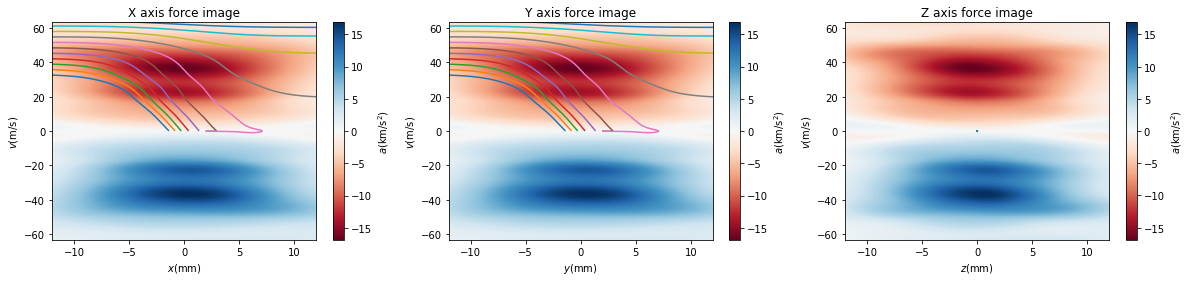

In [125]:
ploting_function_2(**optimizer.max['params'])

In [126]:
def ploting_function_3(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    # v_list = np.linspace(v0s-2,v0s+2,11)
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)


    fig,ax = plt.subplots(1,3,figsize=(20,4))
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')

Completed in 22.36 s.                                               
Completed in 22.37 s.                                               
Completed in 22.02 s.                                               


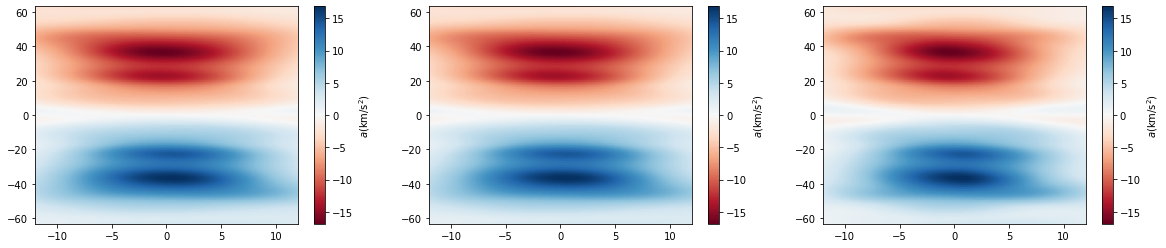

In [127]:
ploting_function_3(**optimizer.max['params'])

In [57]:
optimizer.max['params']

{'Bgrad': 12.108058192065528,
 'd1': -2.8984093075350157,
 'd2': -2.0249059179504143,
 'd3': -2.236092474085846,
 'd4': -2.899788833313781,
 'p1': 4.556630861752742,
 'p2': 7.409576631668102,
 'p3': 38.95031373162466,
 'p4': 26.082941119553826,
 'pol1': 0.5210332184887312,
 'pol2': -0.5944044310855041,
 'pol3': 0.2840471464910028,
 'pol4': -0.11614466679279056,
 'v0s': 5.885502339091453}

In [53]:
fixed = optimizer.max['params'].copy()

In [55]:
fixed['Bgrad']=1.2528

In [58]:
fixed

{'Bgrad': 1.2528,
 'd1': -2.8984093075350157,
 'd2': -2.0249059179504143,
 'd3': -2.236092474085846,
 'd4': -2.899788833313781,
 'p1': 4.556630861752742,
 'p2': 7.409576631668102,
 'p3': 38.95031373162466,
 'p4': 26.082941119553826,
 'pol1': 0.5210332184887312,
 'pol2': -0.5944044310855041,
 'pol3': 0.2840471464910028,
 'pol4': -0.11614466679279056,
 'v0s': 5.885502339091453}

Completed in 22.86 s.                                               
Completed in 23.86 s.                                               
Completed in 22.77 s.                                               
Completed in 6.61 s.                                                  
Completed in 5.56 s.                                                  
Completed in 6.10 s.                                                  
Completed in 9.63 s.                                                  
Completed in 9.41 s.                                                  
Completed in 11.95 s.                                                 
Completed in 15.41 s.                                                 
Completed in 17.62 s.                                                 
Completed in 19.26 s.                                                 
Completed in 19.22 s.                                                 
Completed in 17.20 s.                                                 
7.6293805154

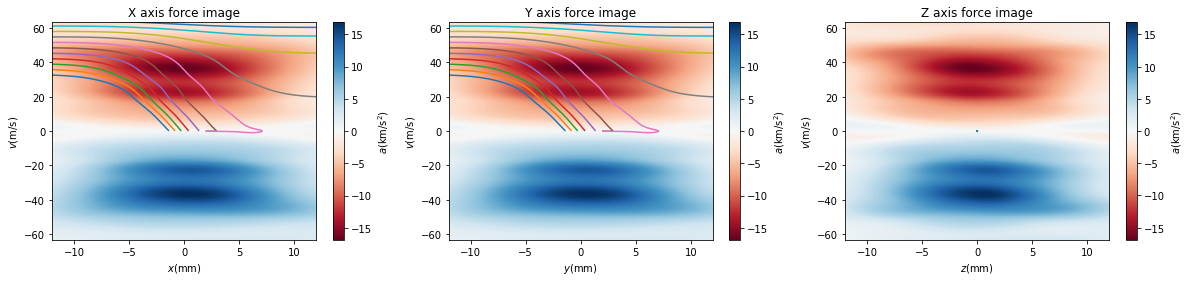

In [141]:
ploting_function_2(**abcd[0]['params'])

In [134]:
import pymongo

In [135]:
from pymongo import MongoClient

In [136]:
connection = MongoClient("localhost:27017")

In [90]:
db = connection.db

In [139]:
abcd = db.vc_0417.find({'target' : {"$gte" : 6}},projection={"_id" : False,"datetime" : False})

In [140]:
abcd[0]['params']

{'Bgrad': 1.3083789721670605,
 'd1': -2.7837243533673544,
 'd2': 0.39630781508745194,
 'd3': -0.3666948999515329,
 'd4': -0.15727871561939688,
 'p1': 16.20716817448353,
 'p2': 19.864176761610437,
 'p3': 23.593750139172112,
 'p4': 21.04460859627699,
 'pol1': -0.8358968032938177,
 'pol2': -0.10204959145757746,
 'pol3': 0.9767316145413344,
 'pol4': 1,
 'v0s': 6.12126281887845}